## Global ocean ventilation

* This notebook ...
* Author: Henri Drake (modified from John Dunne's ferret script: `/net/jpd/ESM4.5/esm4.5_vent_analysis.jnl`)

In [137]:
config = {
    "startyr": 36, # 36 for piControl experiments or 1993 for historical runs starting in 1958
    "endyr": 40, # 40 for piControl experiments or 1997 for historical runs starting in 1958
    "dora_id": "cm5-1",
    "pathPP": None,
}

In [138]:
plot_obs = False

In [139]:
# Make sure this cell is active so that the workflow and Dora can update
# the config dictionary at runtime.

from gfdlnb.tools.update_notebook_config import update_notebook_config
config = update_notebook_config(config)

In [140]:
print(str(config))

{'startyr': 36, 'endyr': 40, 'dora_id': 'cm5-1', 'pathPP': None}


In [141]:
import os
import datetime

### Import Python Modules

In [142]:
import glob
import subprocess

import doralite
import matplotlib.pyplot as plt
import momgrid as mg
import momlevel as ml
import numpy as np
import xarray as xr

In [143]:
# momgrid will use a directory of pre-computed weights
import momgrid
os.environ["MOMGRID_WEIGHTS_DIR"] = "/nbhome/John.Krasting/grid_weights"

### Define Local Parameters

In [144]:
# Define some local variables. These are taken from the doralite object
# or they can be defined locally

if config["dora_id"] is not None:
    experiment =  doralite.dora_metadata(config["dora_id"])
    pathPP = experiment["pathPP"]
    expName = experiment["expName"]
else:
    raise ValueError("Experiment must be defined")

# Define start and end years
start = config["startyr"]
start = int(start) if start is not None else 1

end = config["endyr"]
end = int(end) if end is not None else 9999

### Determine What Files to Load

In [145]:
# Determine what files are needed (leave this up to the developer for flexibility)
# This is an example of what someone might do:

component = "ocean_annual_z"
static = f"{component}/{component}.static.nc"
varname = "ann"

chunk = "annual_5yr"
filelist = sorted(glob.glob(f"{pathPP}{component}/av/{chunk}/{component}.*.{varname}.nc", recursive=True))

def is_in_range(file,start,end):
    start = int(start)
    end = int(end)
    target = set(list(range(start,end+1)))
    fname = os.path.basename(file)
    times = fname.split(".")[1]
    times = times.split("-")
    times = [int(x[0:4]) for x in times]
    candidate = set(list(range(times[0],times[1]+1)))
    return len(candidate.intersection(target)) > 0

filelist = [x for x in filelist if is_in_range(x,start,end)]
staticfile = f"{pathPP}/{static}"

_ = [print(x) for x in filelist]

/archive/Niki.Zadeh/fre/cm5/cm5_c96L65_am5f7c1r0_om5b06_p25_piControl_noBLING_DynVeg_20241009/gfdl.ncrc5-intel23-prod-openmp/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.0036-0040.ann.nc


### DMgetting Files

Dora cannot issue calls to dmget

In [146]:
if not "DORA_EXECUTE" in os.environ.keys():
    print("Calling dmget on files ...")
    cmd = ["dmget"]+filelist+[staticfile]
    _ = subprocess.check_output(cmd)

Calling dmget on files ...


### Establish a Dictionary to Store Scalar Metrics

In [147]:
stats_dict = {}
stats_dict["metadata"] = {
    "expName": str(expName),
    "created": datetime.datetime.now().isoformat(),
}
stats_dict["results"] = {}
stats_dict

{'metadata': {'expName': 'cm5_c96L65_am5f7c1r0_om5b06_p25_piControl_noBLING_DynVeg_20241009',
  'created': '2024-10-22T10:16:55.229289'},
 'results': {}}

### Load model data and grid

In [148]:
# Try first to load a symmetric grid. Older CM4/OM4 runs may need non-symmetric
try:
    ds = momgrid.Gridset(filelist, force_symmetric=True, return_corners=True)
except:
    ds = momgrid.Gridset(filelist, force_symmetric=False, return_corners=True)

model_type = ds.model
ds = ds.data

if "time" in ds.dims:
    ds = ds.sel(time=slice(f"{str(start).zfill(4)}-01-01",f"{str(end).zfill(4)}-12-31")).mean("time")

ds = ds.assign_coords({c.name:c for c in momgrid.vertical.analysis_z_35lev_coord().coords.values()})
ds["dz"] = xr.DataArray(ds.z_i.diff("z_i").values, dims=("z_l",))
ds

<xarray.Dataset> Size: 9GB
Dimensions:                         (xh: 1440, yh: 1161, z_l: 35, z_i: 36,
                                     xq: 1441, yq: 1162, nv: 2)
Coordinates: (12/17)
    time                            object 8B 0038-07-02 12:00:00
  * xh                              (xh) float64 12kB 0.5 1.5 ... 1.44e+03
  * yh                              (yh) float64 9kB 0.5 1.5 ... 1.16e+03
    geolon                          (yh, xh) float32 7MB -299.9 -299.6 ... 60.0
    geolat                          (yh, xh) float32 7MB -88.52 -88.52 ... 64.11
    areacello                       (yh, xh) float32 7MB 7.708e+06 ... 1.201e+06
    ...                              ...
    geolon_v                        (yq, xh) float32 7MB -299.9 -299.6 ... 60.0
    geolat_v                        (yq, xh) float32 7MB -88.57 -88.57 ... 64.11
    areacello_v                     (yq, xh) float32 7MB 7.838e+06 ... 1.201e+06
  * nv                              (nv) float64 16B 1.0 2.0
  * z_l                             (z_l) float64 280B 2.5 10.0 ... 6.5e+03
  * z_i                             (z_i) float64 288B 0.0 5.0 ... 6.75e+03
Data variables: (12/46)
    volcello                        (z_l, yh, xh) float32 234MB dask.array<chunksize=(7, 291, 360), meta=np.ndarray>
    thetao                          (z_l, yh, xh) float32 234MB dask.array<chunksize=(7, 291, 360), meta=np.ndarray>
    thetao_xyave                    (z_l) float32 140B dask.array<chunksize=(35,), meta=np.ndarray>
    so                              (z_l, yh, xh) float32 234MB dask.array<chunksize=(7, 291, 360), meta=np.ndarray>
    so_xyave                        (z_l) float32 140B dask.array<chunksize=(35,), meta=np.ndarray>
    obvfsq                          (z_i, yh, xh) float32 241MB dask.array<chunksize=(8, 291, 360), meta=np.ndarray>
    ...                              ...
    Kd_ePBL                         (z_i, yh, xh) float32 241MB dask.array<chunksize=(8, 291, 360), meta=np.ndarray>
    Kd_work                         (z_l, yh, xh) float32 234MB dask.array<chunksize=(7, 291, 360), meta=np.ndarray>
    time_bnds                       (nv) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
    geolon_c                        (yq, xq) float32 7MB -300.0 -299.8 ... 60.0
    geolat_c                        (yq, xq) float32 7MB -88.57 -88.57 ... 64.06
    dz                              (z_l) float64 280B 5.0 10.0 ... 500.0 500.0
Attributes:
    title:             cm5_c96L65_am5f7c1r0_om5b06_p25_piControl_noBLING_DynV...
    associated_files:  areacello: 00360101.ocean_static.nc
    grid_type:         regular
    grid_tile:         N/A
    comment:           FMS time averaging, version 3.0, precision=double

In [149]:
obs = xr.open_dataset("/archive/oar.gfdl.ogrp-account/MAR/data/Ventilation/glodap/pCFC12.nc")
obs

<xarray.Dataset> Size: 17MB
Dimensions:    (longitude: 360, latitude: 180, depth: 33)
Coordinates:
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * depth      (depth) float64 264B 0.0 10.0 20.0 30.0 ... 4.5e+03 5e+03 5.5e+03
Data variables:
    pCFC12     (depth, longitude, latitude) float32 9MB ...
    pCFC12Err  (depth, longitude, latitude) float32 9MB ...
Attributes:
    title:          Gridded pCFC-12 Data
    authors:        Bob Key
    creation_date:  Jul 28 10:11, 2003

### Compute zonal-depth integrals

In [150]:
from xhistogram.xarray import histogram

In [151]:
def vent(ds):
    max_age = ds.agessc.max(["xh", "yh", "z_l"])
    max_age = max_age.where(max_age > 0, 1.e-12)
    return (max_age - ds.agessc)/max_age

def obs_ventilation_inventory(obs, depth_range=[0, None], scaling_factor=1/350.):
    # Add grid metrics
    obs = obs.assign_coords({"z_i": xr.DataArray(
        np.concatenate([np.array([0]), (obs["depth"][:-1].values + obs["depth"][1:].values) / 2., np.array([5750])]),
        dims = ("z_i",)
    )})
    obs["dz"] = xr.DataArray(obs.z_i.diff("z_i").values, dims=("depth",))
    R = 6378e3
    dlambda = 1. # hard-coded longitudinal resolution of Glodap obs—DO NOT CHANGE
    obs["dx"] = (2*np.pi*R/360)*dlambda*np.cos(np.deg2rad(obs.latitude))

    # integrate in longitude and depth range
    cfc12_inventory = (obs.pCFC12*obs.dx*obs.dz).sel(depth=slice(*depth_range)).sum(["longitude", "depth"])
    cfc12_inventory = cfc12_inventory.where(cfc12_inventory != 0.)
    
    # apply empirical scaling/normalization factor to allow comparison with age-based ventilation metric
    scaled_ventilation_inventory = cfc12_inventory * scaling_factor
    return scaled_ventilation_inventory

def model_ventilation_inventory(ds, depth_range=[0, None], dphi = 2.):
    # Broadcast geolat so that argument for histogram has same dimensions as the weights
    _, geolat = xr.broadcast(ds.agessc, ds.geolat)
    geolat = geolat.rename("latitude")

    # Target coordinate bins
    lat_bins = xr.DataArray(np.arange(-90, 91, dphi), dims=("latitude_bins",))

    # To accomodate the bipolar Arctic grid, instead of integrating along *nominal* longitude variable `xh`,
    # we use xhistogram to do a weighted sum in latitude bins. Because we don't have the correct
    # longitudinal widths of each grid cell, we over-weight the integral by `areacello` and then divide by the 
    # meridional width of each latitude band.
    weights = vent(ds)*ds.areacello*ds.dz
    ventilation_inventory_overweighted = histogram(
        geolat.sel(z_l=slice(*depth_range)),
        bins=lat_bins.values,
        weights=weights.fillna(0.).sel(z_l=slice(*depth_range)),
        dim=["xh", "z_l", "yh"],
        bin_dim_suffix="",
        block_size=None
    )
    R = 6378e3
    meridional_arc_length = (2*np.pi/360) * dphi * R * np.cos(np.deg2rad(ventilation_inventory_overweighted.latitude))
    ventilation_inventory = ventilation_inventory_overweighted / meridional_arc_length
    return ventilation_inventory

In [159]:
def plot_ventilation_inventories(ds_list, obs, depth_range=[0, 10000]):
    obs_vent = obs_ventilation_inventory(obs, depth_range=depth_range)
    plt.plot(
        obs_vent.latitude,
        obs_vent * 1e-10,
        label=rf"GLODAP (circa 1994): $\dfrac{{\int_{{{depth_range[1]}}}^{{{depth_range[0]}}} \left(\int [CFC12] \; dx \right)dz}}{{350 \; \frac{{mol}}{{m^{{3}}}}}}$",
        color="k",
        ls="--"
    )

    plt.plot(
        [], [], label = rf"MODELS (years {config['startyr']}-{config['endyr']}): $\int_{{{depth_range[1]}}}^{{{depth_range[0]}}} \left(\int \frac{{\max(age) - age}}{{\max(age)}} \; dx \right)dz$",
        color="k", ls="-"
    )
    for ds in ds_list:
        ds_vent = model_ventilation_inventory(ds, depth_range=depth_range)
        if "title" in ds.attrs.keys():
            title = ds.title
        else:
            title = expName
        plt.plot(
            ds_vent.latitude,
            ds_vent * 1e-10,
            label = title,
        )
    plt.ylim(0, None)
    plt.xlim(-85, 90)
    plt.ylabel(r"Integrated ventilation [10$^{10}$ m$^{2}$]")
    plt.xlabel("latitude [degrees]")
    plt.title("Integrated normalized ventilation metrics")
    plt.legend()

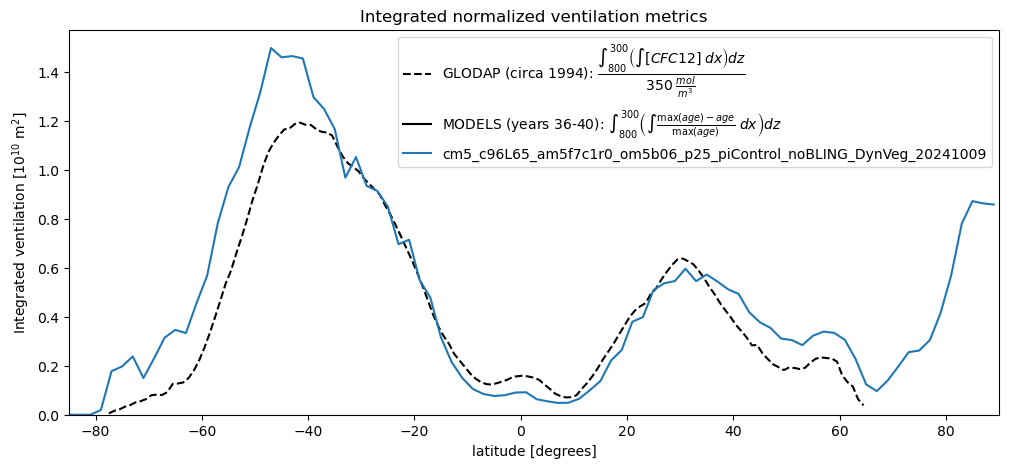

In [160]:
plt.figure(figsize=(12,5))
plot_ventilation_inventories([ds], obs, depth_range=[300,800])

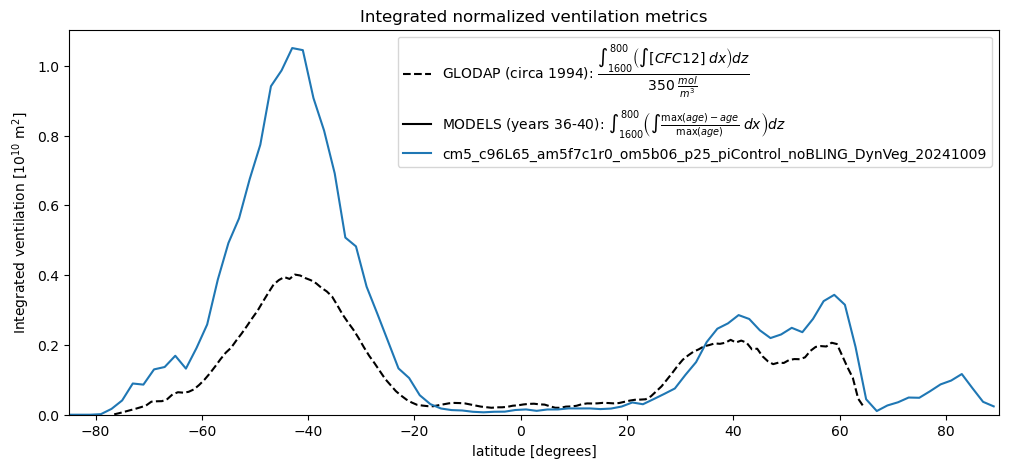

In [161]:
plt.figure(figsize=(12,5))
plot_ventilation_inventories([ds], obs, depth_range=[800,1600])

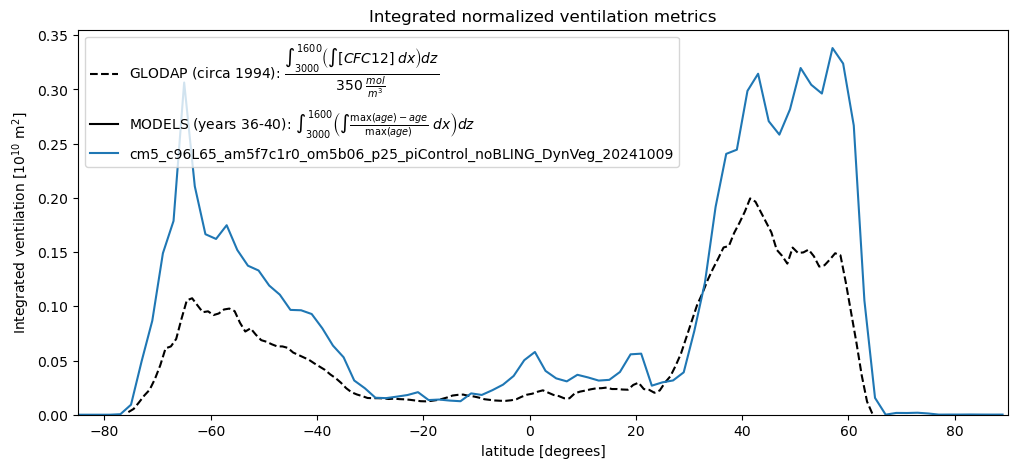

In [162]:
plt.figure(figsize=(12,5))
plot_ventilation_inventories([ds], obs, depth_range=[1600,3000])

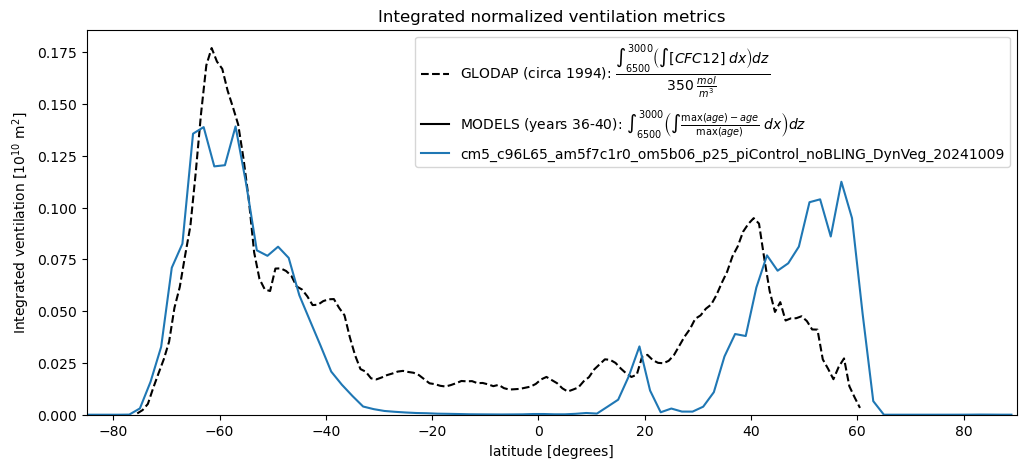

In [163]:
plt.figure(figsize=(12,5))
plot_ventilation_inventories([ds], obs, depth_range=[3000,6500])